In [101]:
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

student_path = 'data/SRA'
llm_path = 'data/SRA_LLM'

student_data_files = [os.path.join(student_path, file) for file in os.listdir(student_path) if file.endswith('.tsv')]
llm_data_files = [os.path.join(llm_path, file) for file in os.listdir(llm_path) if file.endswith('.csv')]

print(str(len(student_data_files)) + "/" + str(len(llm_data_files)) + " files")

88/88 files


In [ ]:
f_scores_student_model = []
f_scores_llm_model = []
f_scores_diff = []

for student_file, llm_file in zip(student_data_files, llm_data_files):
    df_student = pl.read_csv(student_file, separator="\t")
    df_llm = pl.read_csv(llm_file)

    vectorizer = TfidfVectorizer()
    X_student = vectorizer.fit_transform(df_student['AnswerText'])
    X_llm = vectorizer.transform(df_llm['AnswerText'])

    y_student = df_student['Score']
    y_llm = df_llm['Score']

    loo = LeaveOneOut()

    # student answers results
    predictions_student = []
    true_labels_student = []
    for train_index, test_index in loo.split(X_student):
        X_train, X_test = X_student[train_index], X_student[test_index]
        y_train, y_test = y_student[train_index], y_student[test_index]

        svm_model_student = SVC(kernel='rbf')
        svm_model_student.fit(X_train, y_train)
        y_pred = svm_model_student.predict(X_test)

        predictions_student.append(y_pred[0])
        true_labels_student.append(y_test[0])

    f1_student = f1_score(
        true_labels_student, 
        predictions_student,
        average='macro',
        zero_division=0
    )
    f_scores_student_model.append(f1_student)

    # LLM answers results
    predictions_llm = [] 
    true_labels_llm = []
    for train_index, test_index in loo.split(X_student):
        X_train_llm, X_test = X_llm, X_student[test_index]
        y_train_llm, y_test = y_llm, y_student[test_index]

        svm_model_llm = SVC(kernel='rbf')
        svm_model_llm.fit(X_train_llm, y_train_llm)
        y_pred_llm = svm_model_llm.predict(X_test)

        predictions_llm.append(y_pred_llm[0])
        true_labels_llm.append(y_test[0])

    f1_llm = f1_score(
        true_labels_llm,
        predictions_llm,
        average='macro',
        zero_division=0
    )
    f_scores_llm_model.append(f1_llm)
    f_scores_diff.append(f1_student - f1_llm)
    
    print("%.2f" % f1_student + "/" + "%.2f" % f1_llm + "/" + "%.2f" % (f1_student-f1_llm))


0.54/0.00/0.54
0.77/0.36/0.41
0.45/0.38/0.07
0.75/0.51/0.23
0.56/0.04/0.52
0.23/0.09/0.13
0.50/0.11/0.39
0.37/0.10/0.27
0.25/0.10/0.15
0.32/0.05/0.27
0.65/0.28/0.37
0.25/0.16/0.10
0.42/0.43/-0.01
0.44/0.16/0.28
0.33/0.06/0.27
0.52/0.03/0.50
0.70/0.05/0.66
0.70/0.05/0.65
0.18/0.18/-0.00
0.39/0.40/-0.01
0.32/0.12/0.20
0.48/0.00/0.48
0.39/0.04/0.35
0.59/0.59/0.00
0.67/0.18/0.50
0.61/0.42/0.19
0.92/0.51/0.41
0.39/0.10/0.29
0.51/0.02/0.49
0.29/0.20/0.09
0.45/0.41/0.04
0.36/0.17/0.19
0.68/0.10/0.58
0.33/0.21/0.12
0.40/0.28/0.13
0.49/0.18/0.31
0.44/0.25/0.19
0.52/0.43/0.09
0.40/0.26/0.14
0.63/0.39/0.24
0.42/0.18/0.24
0.32/0.07/0.25
0.48/0.42/0.06
0.65/0.23/0.42
0.63/0.09/0.55
0.39/0.39/-0.00
0.51/0.52/-0.01
0.43/0.00/0.43
0.57/0.13/0.44
0.67/0.01/0.67
0.60/0.57/0.03
0.62/0.58/0.04
0.62/0.11/0.51
0.71/0.05/0.66
0.41/0.39/0.01
0.44/0.10/0.34
0.39/0.17/0.22
0.33/0.31/0.02
0.68/0.68/0.00
0.74/0.65/0.09
0.24/0.20/0.04
0.63/0.07/0.56
0.59/0.00/0.59
0.71/0.00/0.71
0.52/0.36/0.16
0.48/0.14/0.33
0.54/

In [140]:
data = {"student": f_scores_student_model, "llm": f_scores_llm_model, "diff": f_scores_diff}

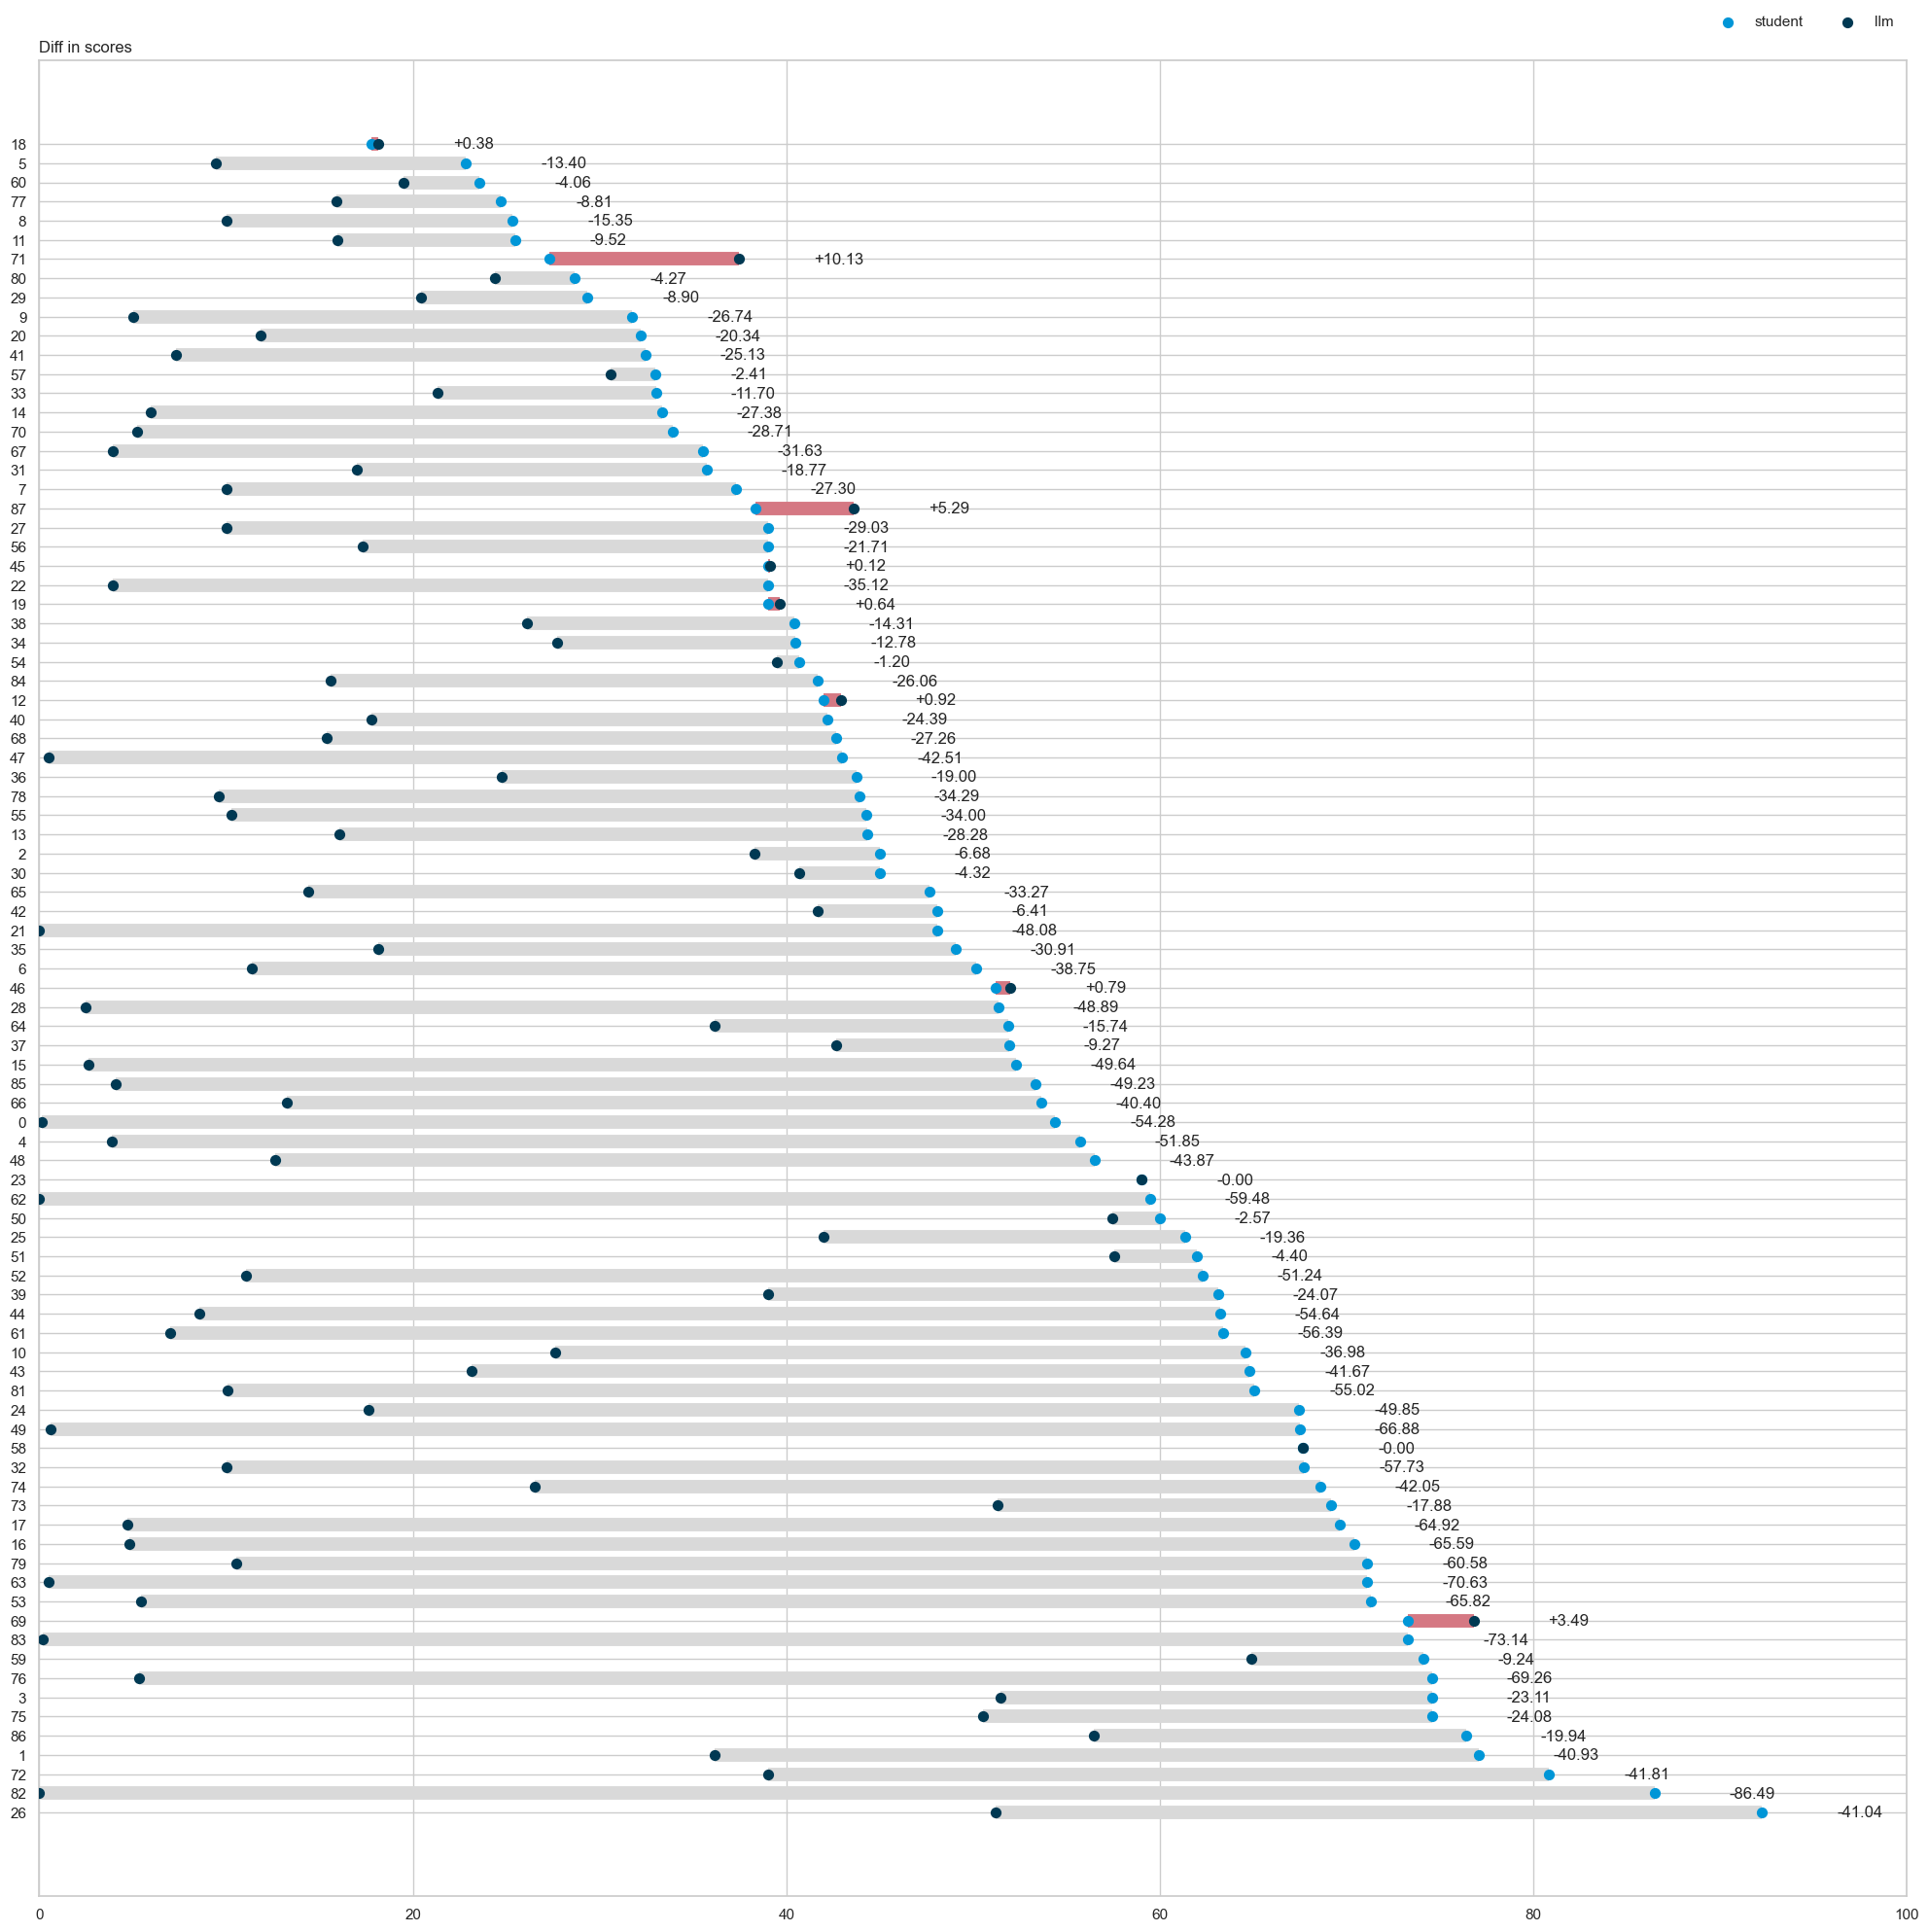

In [141]:
import pandas as pd
fscore_df = pd.DataFrame(data)
sorted = fscore_df.sort_values(by = "student", ascending=False)
sorted["student"] = sorted["student"] * 100
sorted["llm"] = sorted["llm"] * 100
sorted["diff"] = sorted["diff"] * 100

plt.figure(figsize=(20,20))
y_range = np.arange(1, len(sorted.index) + 1)
colors = np.where(sorted['student'] > sorted['llm'], '#d9d9d9', '#d57883')
plt.hlines(y=y_range, xmin=sorted['student'], xmax=sorted['llm'],
           color=colors, lw=10)
plt.scatter(sorted['student'], y_range, color='#0096d7', s=50, label='student', zorder=3)
plt.scatter(sorted['llm'], y_range, color='#003953', s=50 , label='llm', zorder=3)
for (_, row), y in zip(sorted.iterrows(), y_range):
    plt.annotate(f"{-row['diff']:+.2f}", (max(row["student"], row["llm"]) + 4, y - 0.25))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)

plt.yticks(y_range, sorted.index)
plt.title("Diff in scores", loc='left')
plt.xlim(0, 100)
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

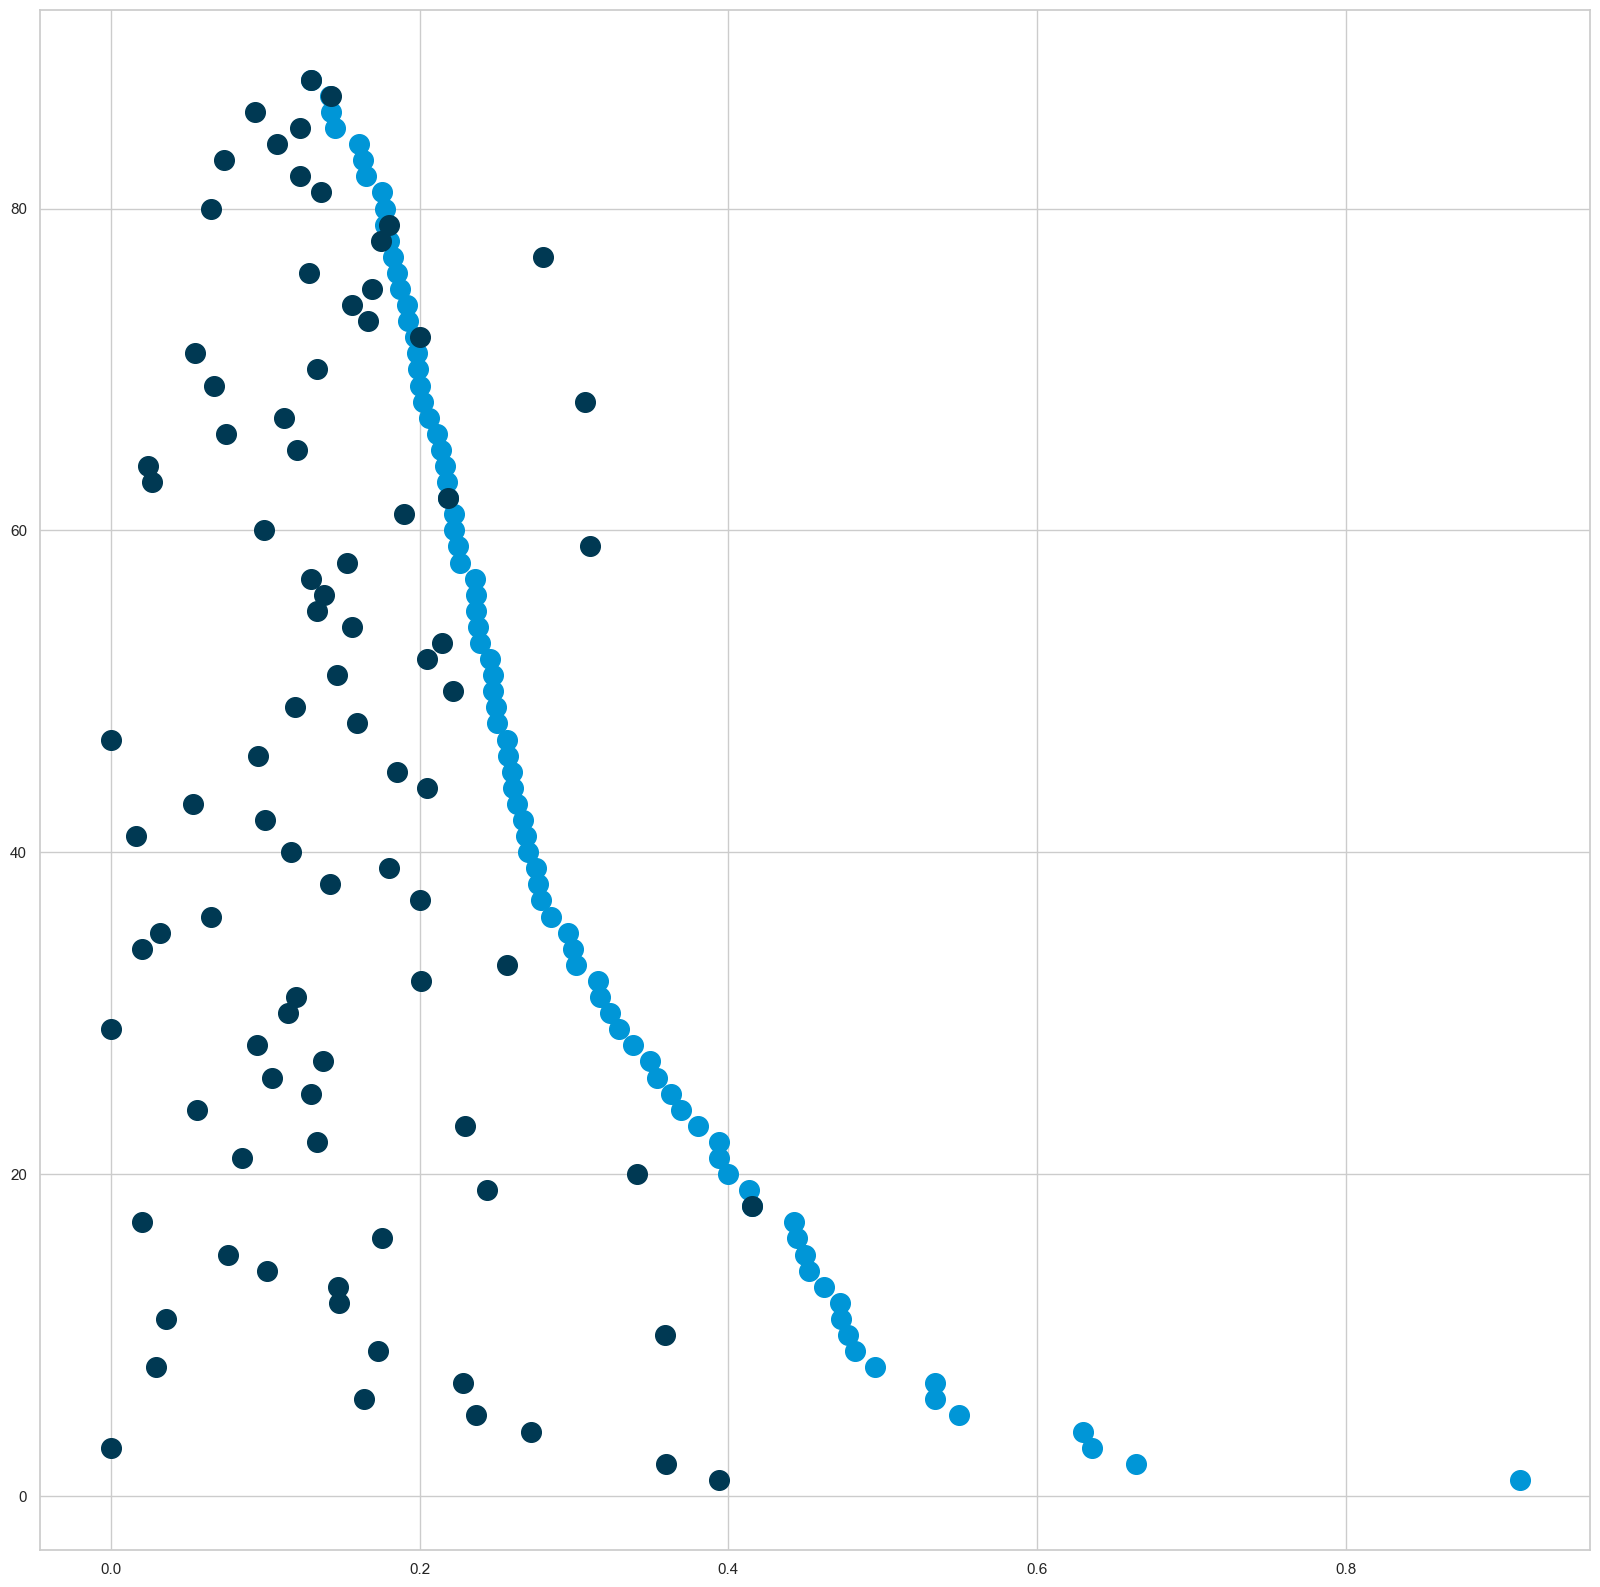

In [138]:
f1_df = pl.DataFrame(data)
f1_df = f1_df.sort("student", descending=True)

plt.figure(figsize=(20,20))
y_range = np.arange(1, f1_df['student'].count() + 1)
colors = np.where(f1_df['student'] > f1_df['llm'], '#d9d9d9', '#d57883')
plt.hlines(y=y_range, xmin=f1_df['student'], xmax=f1_df['student'],
           color=colors, lw=10)
plt.scatter(f1_df['student'], y_range, color='#0096d7', s=200, label='student', zorder=3)
plt.scatter(f1_df['llm'], y_range, color='#003953', s=200 , label='llm', zorder=3)
for (_, row), y in zip(f1_df.rows(), y_range):
    plt.annotate(f"{row['diff']:+.0%}", (max(row["student"], row["llm"]) + 4, y - 0.25))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)

plt.yticks(y_range, [i for i in range(f1_df.rows())])
plt.title("Diff in scores", loc='left')
plt.xlim(50, 300)
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

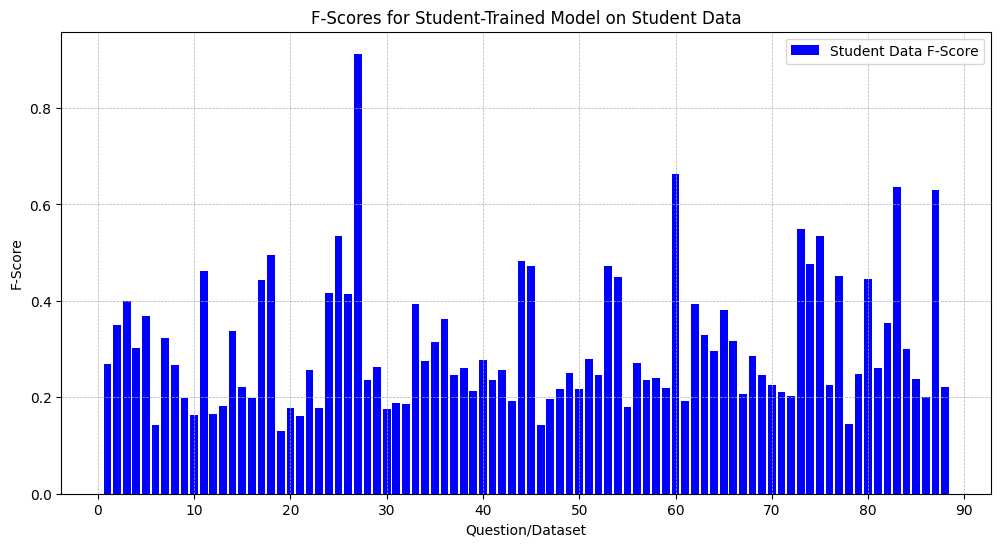

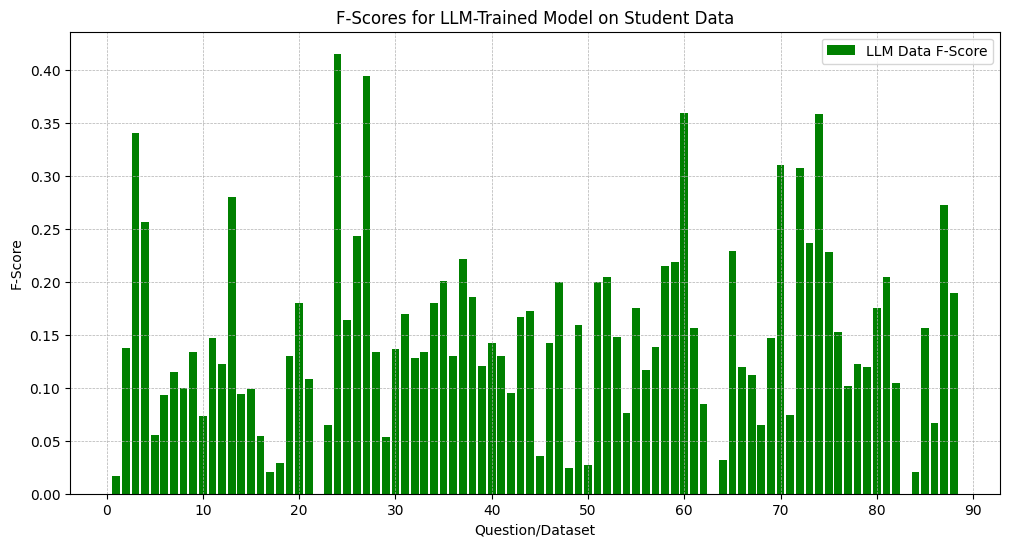

TypeError: 'DataFrame' object is not callable

In [104]:
# Generiere den Range für die Fragen/Datasets
questions = np.arange(1, len(f_scores_student_model) + 1)

# Plot F-Scores für das Student-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_student_model, label='Student Data F-Score', color='blue')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for Student-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Plot F-Scores für das LLM-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_llm_model, label='LLM Data F-Score', color='green')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for LLM-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Kombiniere Fragen und F-Scores in eine Liste von Tupeln
combined_scores = list(zip(questions, f_scores_student_model, f_scores_llm_model))

# Sortiere die kombinierten Scores basierend auf dem Student F-Score (größte zuerst)
sorted_combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)

# Entzippe die sortierte Liste zurück in separate Listen
sorted_questions, sorted_student_scores, sorted_llm_scores = zip(*sorted_combined_scores)

# In numpy Arrays umwandeln
sorted_questions = np.array(sorted_questions)
sorted_student_scores = np.array(sorted_student_scores)
sorted_llm_scores = np.array(sorted_llm_scores)

# Kombinierter Bar-Plot mit Differenzindikation
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35
ax.bar(np.arange(len(sorted_questions)) - width/2, sorted_student_scores, width, label='Student-Trained Model', color='blue')

# Differenz farblich markieren
for i, (f_student, f_llm) in enumerate(zip(sorted_student_scores, sorted_llm_scores)):
    if f_llm > f_student:
        ax.bar(i + width/2, f_llm, width, color='green')
    elif f_llm < f_student:
        ax.bar(i + width/2, f_llm, width, color='red')
    else:
        ax.bar(i + width/2, f_llm, width, color='yellow')

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('F-Score')
ax.set_title('Comparison of F-Scores for Student and LLM-Trained Models on Student Data')
ax.legend(['Student-Trained Model', 'LLM-Trained Model (Green = Higher, Red = Lower, Yellow = Same)'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Bar-Plot, der nur die Unterschiede zeigt
fig, ax = plt.subplots(figsize=(12, 6))

differences = [f_student - f_llm for f_student, f_llm in zip(sorted_student_scores, sorted_llm_scores)]
colors = ['green' if diff > 0 else 'red' if diff < 0 else 'yellow' for diff in differences]

ax.bar(np.arange(len(sorted_questions)), differences, width, color=colors)

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('Difference in F-Score')
ax.set_title('Difference in F-Scores Between LLM and Student-Trained Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Erstelle eine Tabelle mit den F-Scores
f_scores_table = pd.DataFrame({
    'Question': sorted_questions,
    'Student-Trained F-Score': sorted_student_scores,
    'LLM-Trained F-Score': sorted_llm_scores,
    'Difference (Student - LLM)': differences
})

# Tabelle anzeigen
print(f_scores_table)


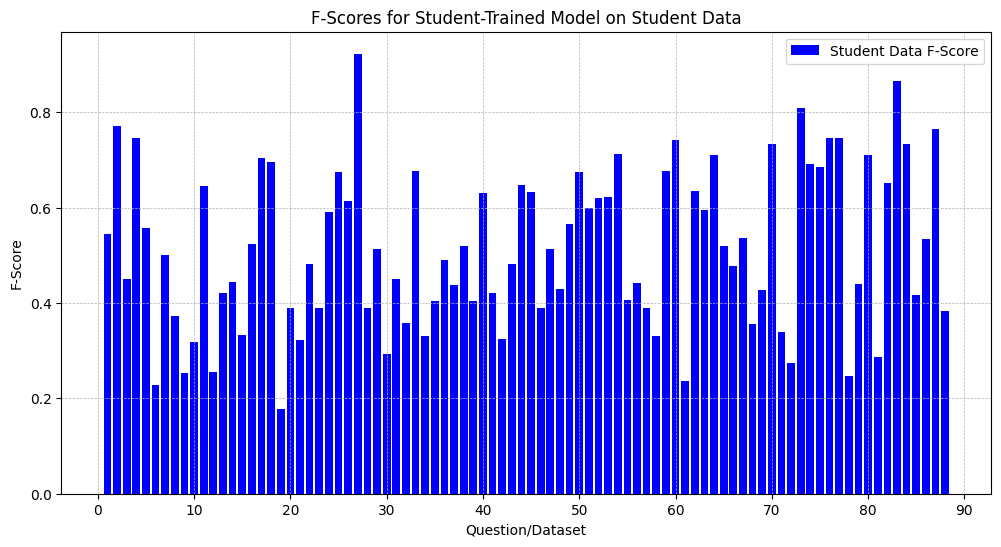

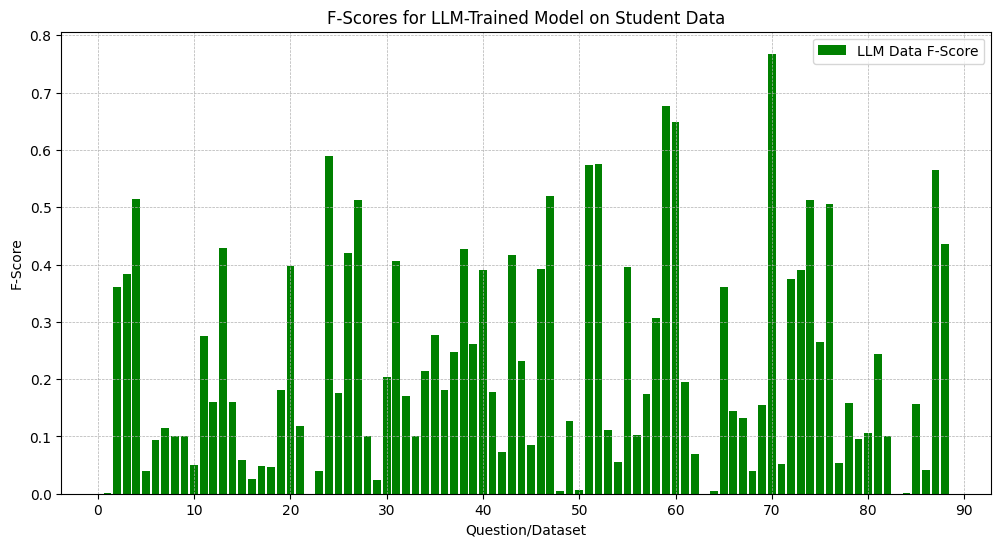

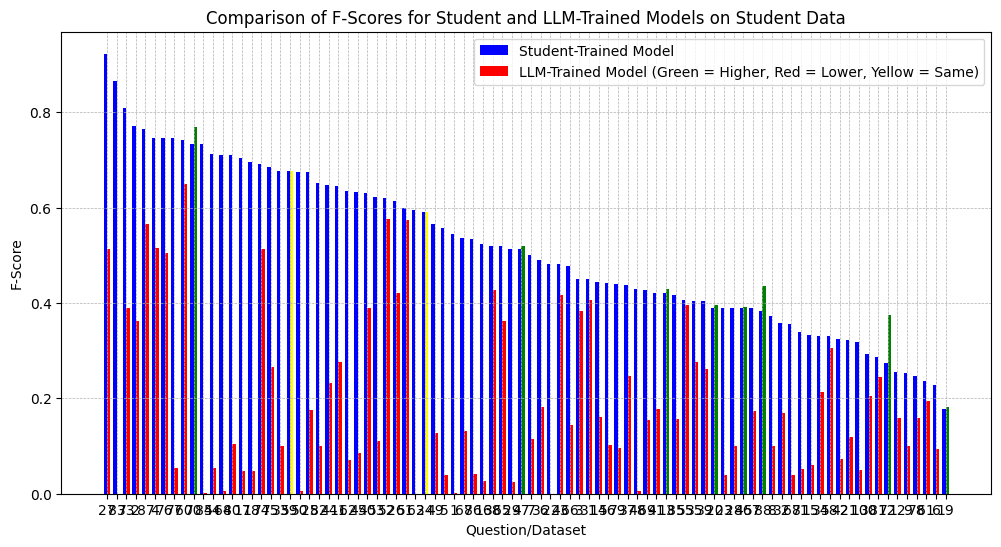

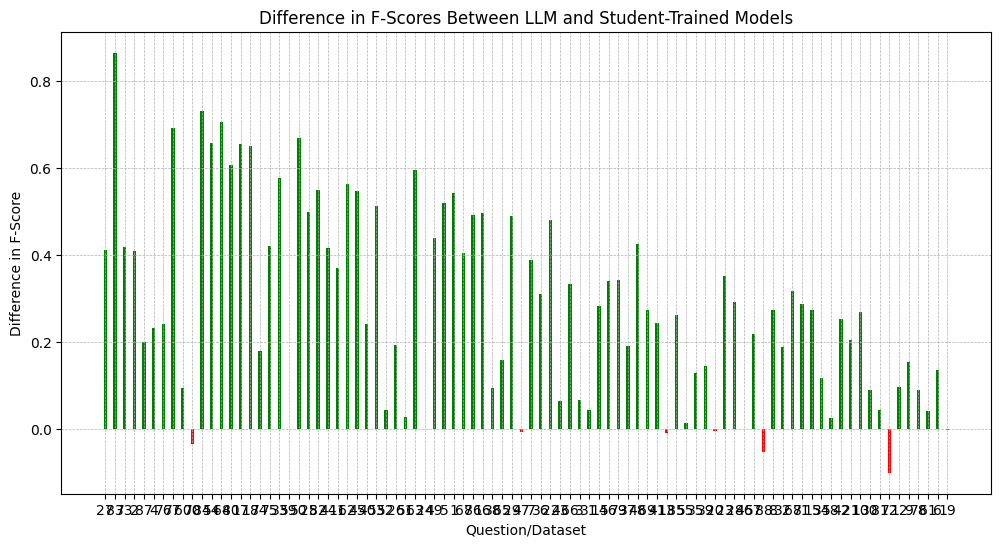

    Question  ...  Difference (Student - LLM)
0         27  ...                    0.410424
1         83  ...                    0.864862
2         73  ...                    0.418116
3          2  ...                    0.409346
4         87  ...                    0.199401
..       ...  ...                         ...
83         9  ...                    0.153509
84        78  ...                    0.088089
85        61  ...                    0.040584
86         6  ...                    0.134026
87        19  ...                   -0.003840

[88 rows x 4 columns]


In [ ]:

# Generiere den Range für die Fragen/Datasets
questions = np.arange(1, len(f_scores_student_model) + 1)

# Plot F-Scores für das Student-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_student_model, label='Student Data F-Score', color='blue')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for Student-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Plot F-Scores für das LLM-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_llm_model, label='LLM Data F-Score', color='green')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for LLM-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Kombiniere Fragen und F-Scores in eine Liste von Tupeln
combined_scores = list(zip(questions, f_scores_student_model, f_scores_llm_model))

# Sortiere die kombinierten Scores basierend auf dem Student F-Score (größte zuerst)
sorted_combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)

# Entzippe die sortierte Liste zurück in separate Listen
sorted_questions, sorted_student_scores, sorted_llm_scores = zip(*sorted_combined_scores)

# In numpy Arrays umwandeln
sorted_questions = np.array(sorted_questions)
sorted_student_scores = np.array(sorted_student_scores)
sorted_llm_scores = np.array(sorted_llm_scores)

# Kombinierter Bar-Plot mit Differenzindikation
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35
ax.bar(np.arange(len(sorted_questions)) - width/2, sorted_student_scores, width, label='Student-Trained Model', color='blue')

# Differenz farblich markieren
for i, (f_student, f_llm) in enumerate(zip(sorted_student_scores, sorted_llm_scores)):
    if f_llm > f_student:
        ax.bar(i + width/2, f_llm, width, color='green')
    elif f_llm < f_student:
        ax.bar(i + width/2, f_llm, width, color='red')
    else:
        ax.bar(i + width/2, f_llm, width, color='yellow')

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('F-Score')
ax.set_title('Comparison of F-Scores for Student and LLM-Trained Models on Student Data')
ax.legend(['Student-Trained Model', 'LLM-Trained Model (Green = Higher, Red = Lower, Yellow = Same)'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Bar-Plot, der nur die Unterschiede zeigt
fig, ax = plt.subplots(figsize=(12, 6))

differences = [f_student - f_llm for f_student, f_llm in zip(sorted_student_scores, sorted_llm_scores)]
colors = ['green' if diff > 0 else 'red' if diff < 0 else 'yellow' for diff in differences]

ax.bar(np.arange(len(sorted_questions)), differences, width, color=colors)

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('Difference in F-Score')
ax.set_title('Difference in F-Scores Between LLM and Student-Trained Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Erstelle eine Tabelle mit den F-Scores
f_scores_table = pd.DataFrame({
    'Question': sorted_questions,
    'Student-Trained F-Score': sorted_student_scores,
    'LLM-Trained F-Score': sorted_llm_scores,
    'Difference (Student - LLM)': differences
})

# Tabelle anzeigen
print(f_scores_table)


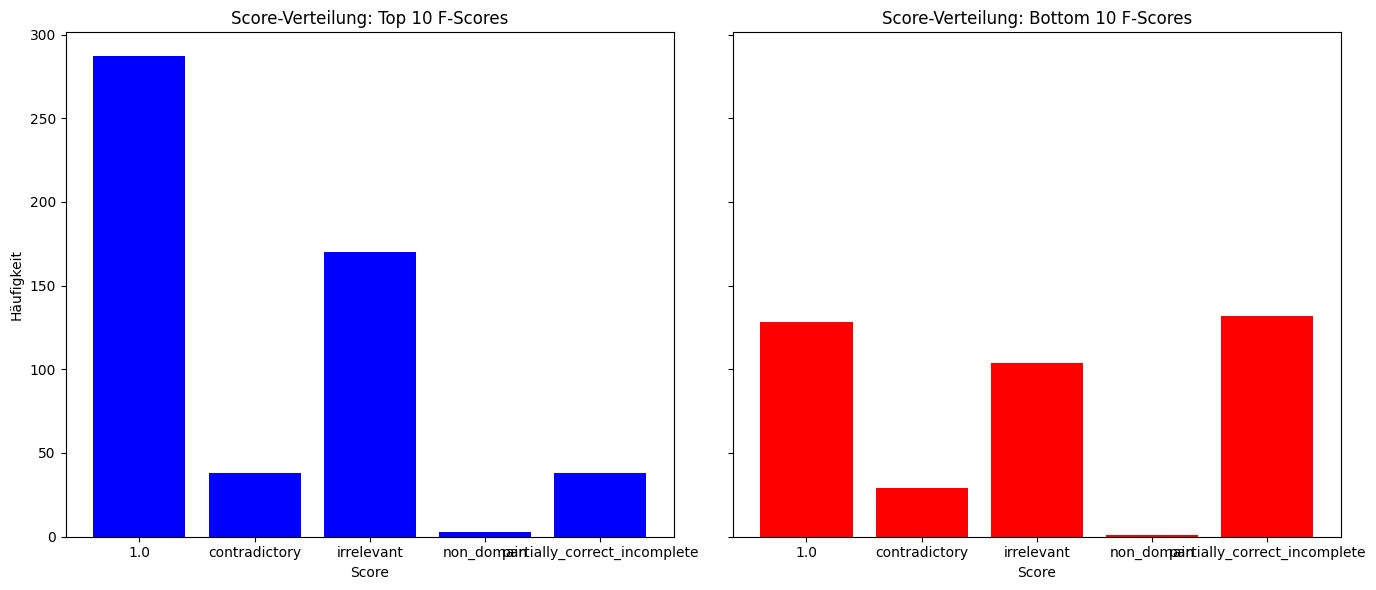

In [ ]:
# Extrahiere die Indizes für die 10 höchsten und 10 niedrigsten F-Scores
top_10_indices = np.argsort(f_scores_student_model)[-10:][::-1]  # 10 höchste F-Scores
bottom_10_indices = np.argsort(f_scores_student_model)[:10]     # 10 niedrigste F-Scores

# Funktion zur Erstellung der Score-Verteilungsdaten
def get_score_distribution(indices, data_files):
    score_distributions = []
    for idx in indices:
        file_path = data_files[idx]
        data = pd.read_csv(file_path, sep="\t")
        score_distributions.append(data['Score'].value_counts())
    return score_distributions

# Verteilungen für die höchsten und niedrigsten F-Scores
top_10_distributions = get_score_distribution(top_10_indices, student_data_files)
bottom_10_distributions = get_score_distribution(bottom_10_indices, student_data_files)

# Kombinierte Verteilungen erstellen
def combine_distributions(distributions):
    combined = pd.DataFrame(distributions).fillna(0).sum()
    combined = combined.sort_index()  # Sortiere nach Score-Werten
    return combined

top_10_combined = combine_distributions(top_10_distributions)
bottom_10_combined = combine_distributions(bottom_10_distributions)

# Visualisierung der Verteilungen
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Verteilung für die höchsten F-Scores
axes[0].bar(top_10_combined.index, top_10_combined.values, color='blue')
axes[0].set_title("Score-Verteilung: Top 10 F-Scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Häufigkeit")

# Verteilung für die niedrigsten F-Scores
axes[1].bar(bottom_10_combined.index, bottom_10_combined.values, color='red')
axes[1].set_title("Score-Verteilung: Bottom 10 F-Scores")
axes[1].set_xlabel("Score")

plt.tight_layout()
plt.show()


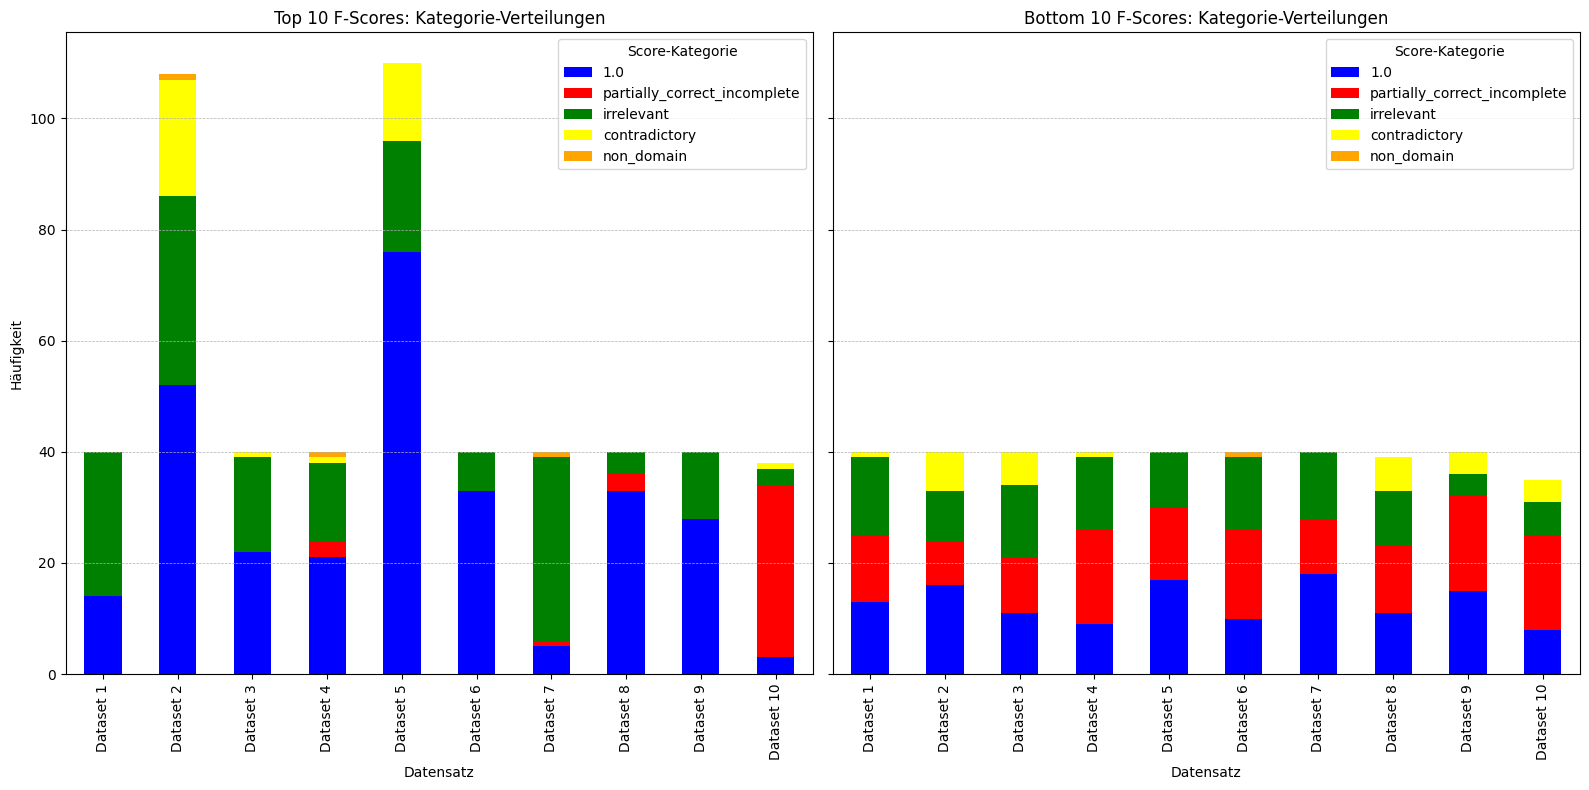

Top 10 F-Scores:
   Dataset                        Filename  F-Score
 Dataset 1 SRA_allAnswers_promptMS_43b.tsv 0.922545
 Dataset 2  SRA_allAnswers_promptPS_2a.tsv 0.864862
 Dataset 3 SRA_allAnswers_promptMS_50a.tsv 0.808438
 Dataset 4   SRA_allAnswers_promptVB_1.tsv 0.770821
 Dataset 5  SRA_allAnswers_promptPS_2b.tsv 0.764015
 Dataset 6 SRA_allAnswers_promptFN_27b.tsv 0.745890
 Dataset 7 SRA_allAnswers_promptEM_45c.tsv 0.745890
 Dataset 8 SRA_allAnswers_promptMS_64a.tsv 0.745890
 Dataset 9 SRA_allAnswers_promptFN_17a.tsv 0.741176
Dataset 10 SRA_allAnswers_promptLF_31b.tsv 0.733028

Bottom 10 F-Scores:
   Dataset                         Filename  F-Score
 Dataset 1  SRA_allAnswers_promptII_24b.tsv 0.177641
 Dataset 2  SRA_allAnswers_promptLF_13a.tsv 0.228571
 Dataset 3   SRA_allAnswers_promptSE_44.tsv 0.235833
 Dataset 4   SRA_allAnswers_promptEM_46.tsv 0.247273
 Dataset 5   SRA_allAnswers_promptMS_39.tsv 0.253509
 Dataset 6 SRA_allAnswers_promptLF_26a2.tsv 0.254654
 Dataset 7  SRA_all

In [ ]:
# Farben für die Kategorien definieren
category_colors = {
    "1.0": "blue",
    "partially_correct_incomplete": "red",
    "irrelevant": "green",
    "contradictory": "yellow",
    "non_domain": "orange"
}

# Funktion zur Erstellung der Kategorie-Verteilungen für einzelne Indizes
def get_category_distributions(indices, data_files):
    distributions = []
    for idx in indices:
        file_path = data_files[idx]
        data = pd.read_csv(file_path, sep="\t")
        category_counts = data['Score'].value_counts().reindex(category_colors.keys(), fill_value=0)
        distributions.append(category_counts)
    return pd.DataFrame(distributions).fillna(0).reset_index(drop=True)

# Verteilungen für die höchsten und niedrigsten F-Scores
top_10_categories = get_category_distributions(top_10_indices, student_data_files)
bottom_10_categories = get_category_distributions(bottom_10_indices, student_data_files)

# Funktion zur Visualisierung der Kategorie-Verteilungen
def plot_category_distributions(data, title, ax):
    data.index = [f"Dataset {i+1}" for i in range(len(data))]
    data.plot(
        kind="bar",
        stacked=True,
        color=[category_colors[cat] for cat in data.columns],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Datensatz")
    ax.set_ylabel("Häufigkeit")
    ax.legend(title="Score-Kategorie")
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Top 10 F-Scores
plot_category_distributions(top_10_categories, "Top 10 F-Scores: Kategorie-Verteilungen", axes[0])

# Bottom 10 F-Scores
plot_category_distributions(bottom_10_categories, "Bottom 10 F-Scores: Kategorie-Verteilungen", axes[1])

plt.tight_layout()
plt.show()


# Erstelle eine Tabelle für die höchsten F-Scores
top_10_table = pd.DataFrame({
    "Dataset": [f"Dataset {i+1}" for i in range(10)],
    "Filename": [os.path.basename(student_data_files[idx]) for idx in top_10_indices],
    "F-Score": [f_scores_student_model[idx] for idx in top_10_indices]
})

# Erstelle eine Tabelle für die niedrigsten F-Scores
bottom_10_table = pd.DataFrame({
    "Dataset": [f"Dataset {i+1}" for i in range(10)],
    "Filename": [os.path.basename(student_data_files[idx]) for idx in bottom_10_indices],
    "F-Score": [f_scores_student_model[idx] for idx in bottom_10_indices]
})

# Ausgabe der Tabellen
print("Top 10 F-Scores:")
print(top_10_table.to_string(index=False))

print("\nBottom 10 F-Scores:")
print(bottom_10_table.to_string(index=False))
